Customising MobilenetV2

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s

In [4]:
!git clone https://github.com/coick4698/garbage_classification.git

from google.colab import drive
drive.mount('/content/drive')

%cd /content/garbage_classification

import sys
sys.path.append('/content/garbage_classification/src')

from dataset import get_dataloaders
from model import get_mobilenetv2
from train import train_model
from gradcam_utils import run_gradcam
from utils import plot_accuracy, plot_confusion_matrix

# 데이터 경로 고정
data_path = '/content/drive/MyDrive/iss_project/garbage_classification'

fatal: destination path 'garbage_classification' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/garbage_classification


Epoch [1/10] Train Acc: 68.24%, Val Acc: 76.47%
Epoch [2/10] Train Acc: 80.07%, Val Acc: 84.52%
Epoch [3/10] Train Acc: 83.16%, Val Acc: 82.37%
Epoch [4/10] Train Acc: 85.39%, Val Acc: 80.42%
Epoch [5/10] Train Acc: 87.10%, Val Acc: 87.81%
Epoch [6/10] Train Acc: 88.34%, Val Acc: 86.36%
Epoch [7/10] Train Acc: 89.52%, Val Acc: 84.47%
Epoch [8/10] Train Acc: 89.79%, Val Acc: 85.51%
Epoch [9/10] Train Acc: 90.45%, Val Acc: 87.71%
Epoch [10/10] Train Acc: 91.41%, Val Acc: 85.61%


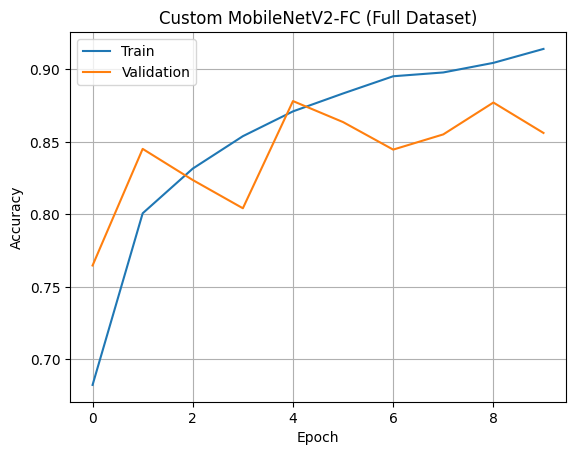

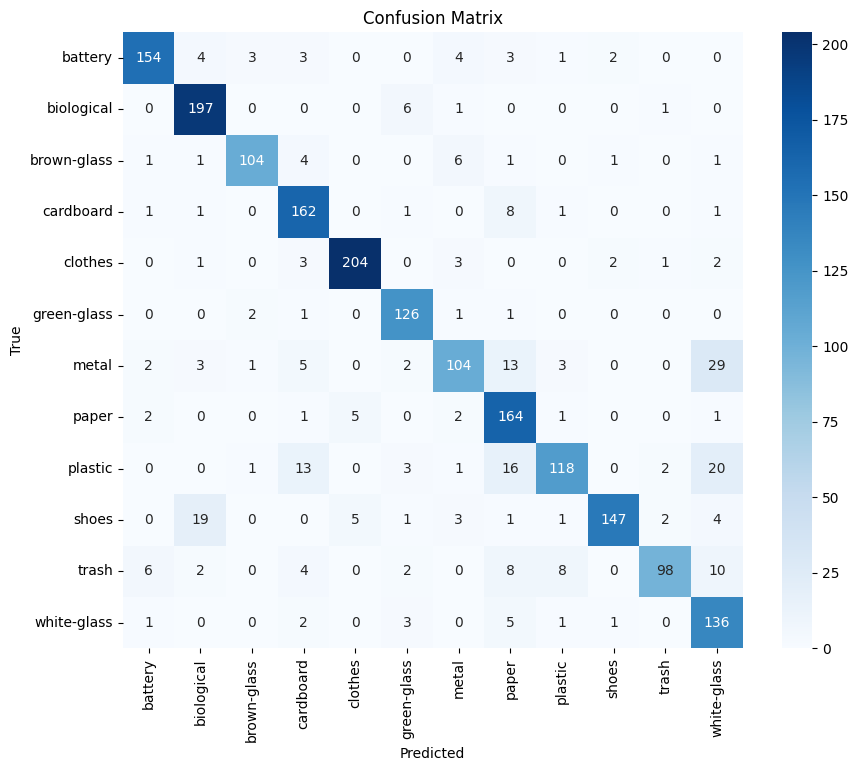

Classification Report:
              precision    recall  f1-score   support

     battery       0.92      0.89      0.90       174
  biological       0.86      0.96      0.91       205
 brown-glass       0.94      0.87      0.90       119
   cardboard       0.82      0.93      0.87       175
     clothes       0.95      0.94      0.95       216
 green-glass       0.88      0.96      0.92       131
       metal       0.83      0.64      0.72       162
       paper       0.75      0.93      0.83       176
     plastic       0.88      0.68      0.77       174
       shoes       0.96      0.80      0.88       183
       trash       0.94      0.71      0.81       138
 white-glass       0.67      0.91      0.77       149

    accuracy                           0.86      2002
   macro avg       0.87      0.85      0.85      2002
weighted avg       0.87      0.86      0.85      2002



In [13]:
# Exp.1 - Edit structure of FC layer -> increase accuracy  - 40m
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import os

class CustomMobileNetV2_FC(nn.Module):
    def __init__(self, num_classes=12):
        super(CustomMobileNetV2_FC, self).__init__()
        base_model = mobilenet_v2(weights='IMAGENET1K_V1')
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # FC layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)

        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 2. load data
train_loader, val_loader, class_names = get_dataloaders(data_path, use_small=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. load model
model = CustomMobileNetV2_FC(num_classes=12).to(device)
train_acc, val_acc = train_model(model, train_loader, val_loader, num_epochs=10, device=device)

# 4. Accuracy Plot
plot_accuracy(train_acc, val_acc, title="Custom MobileNetV2-FC (Full Dataset)")

# 5. Confusion Matrix
plot_confusion_matrix(model, val_loader, class_names, device=device)

# 6. Precision / Recall / F1-score
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))